# Capstone Project - Distracted Driver Detection
![](https://frontiersinblog.files.wordpress.com/2017/11/age-gender-personality-distracted-driving.jpg?w=940)

# Problem Statement

According to a Road Traffic Injuries report by the [World Health Organisation](https://www.who.int/news-room/fact-sheets/detail/road-traffic-injuries), lives of approximately 1.35 million people around the world each year are cut short as a result of a road traffic crash. It is reported to be the leading cause of death for children and young adults aged 5-29 years.  

Between 20 and 50 million more people suffer non-fatal injuries, with many incurring a disability as a result of their injury. And it is this resultant disability that considerable economic costs is incurred by individuals, their family and the nation as whole. These losses arise from the cost of treatment as well as lost productivity for those killed or disabled by their injuries, and for family members who need to take time off work or school to care for the injured. Road traffic crashes cost most countries 3% of their gross domestic product.

So why are there so many road traffic crashes in the first place? 

One of the main leading cause is **Distracted Driving**. Distracted driving refers to the act of driving while engaging in other activities which diverts attention away from safe driving. Mobile phones are the main culprit of distracted driving. A study found that driving and talking on a mobile phone simultaneously quadruples the risk of crashing. The reaction time of a driver is slowed down by 38%, which is three times more than drinking and driving when surfing social media on your phone while driving. Other examples of distracted driving include:
* Operating the radio/GPS
* Drinking
* Doing hair and makeup
* Reaching behind
* Talking to passenger

In the United States alone, 25-50% of all auto vehicle crashes are directly related to driver distraction with nine percent of fatal crashes in 2016 were reported as distraction-affected crashes. In Singapore, 59 motorists died and 2,710 were injured during a one-year period as a result of drivers failing to keep a proper lookout on our roads.

In light of this, we will use dataset of 2D dashboard images of drivers from State Farm Insurance Company to build a multiclassifer model using Convultionary Neural Network(CNN) to detect and classify images of drivers as either safe driving, or any of the various examples of distracted driving such as texting or talking on the mobile phone. Our measure of success will be maximising the CNN accuracy and minimising the CNN loss.

We hope that this model will aide transport authorities around the world in keeping the roads safe by identifying and penalising these errant and reckless drivers, and hopefully deter drivers from being distracted on the road 

# Executive Summary

Our goal is to train a be able to train a Convultionary Neural Network(CNN) model to detect distracted drivers by classifying them accurately into the labels below:

* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

We leveraged on the 2D dashboard images that were taken from an controlled experiment conducted by State Farm Insurance Company as the dataset for our project. To efficiently run our model, we will normalize our images to the same size and convert them to gray scale images since color is not an essential factor in detecting distracted driving. 

In [ ]:
!pip install zipfile38

  Created wheel for zipfile38: filename=zipfile38-0.0.3-cp36-none-any.whl size=22764 sha256=20a6c6027fd287fcc44230e7afd9f7a70750d584f9e2e2692b152f414d0c5f8c
  Stored in directory: /root/.cache/pip/wheels/15/7a/ec/508d28bf3894e050aef4d0205cdf27a346e6e0891e979345d4
Successfully built zipfile38


In [ ]:
#import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 
import os
import cv2
import itertools
import random
from skimage import color

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator


%matplotlib inline

# Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import zipfile38
# with zipfile38.ZipFile('/content/drive/MyDrive/capstone/imgs_gc.zip', 'r') as zip_ref:
#   zip_ref.extractall('/content/drive/MyDrive/capstone/assets')

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import Dataset

In [ ]:
train_path = "/content/drive/MyDrive/capstone/datasets/driver_imgs_list.csv"
train = pd.read_csv(train_path)
print('Number of samples in trainset : {}'.format(train.shape[0]))
print('Number of classes to predict : {}'.format(len((train.classname).unique())))
train.head()

Number of samples in trainset : 22424
Number of classes to predict : 10


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


Analyzing the driver images list:

* **subject**
  - unique ID of a driver an image that was taken  
* **classname** 
  - class label of the image that we will need to predict images into  
* **img**
  - label of the image
  
On first impressions, there are duplicated driver IDs within a class. This could pose potential problems they are like "duplicates" that will cause the model to predict with the same information in the validation data.

We will hence spilt the the data by driver ID so that we can get a more realistic results from our model. 

# Exploratory Data Analysis

The 10 classes to predict are:

* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

Text(0.5, 1.0, 'Categories Distribution')

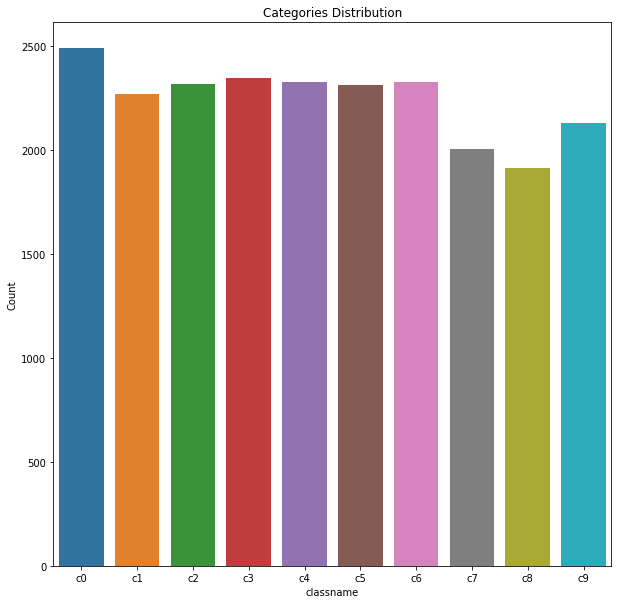

In [ ]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = train)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')

Data is among the classes are somewhat balanced to an acceptable level.

# Overview of Images

We will take a look at the various examples of images in the dataset for each of the 10 classes. 

In [ ]:
classes = {"c0": "safe driving", 
           "c1": "texting - right", 
           "c2": "talking on the phone - right", 
           "c3": "texting - left",
           "c4": "talking on the phone - left", 
           "c5": "operating the radio", 
           "c6": "drinking", 
           "c7": "reaching behind",
           "c8": "hair and makeup", 
           "c9": "talking to passenger"}

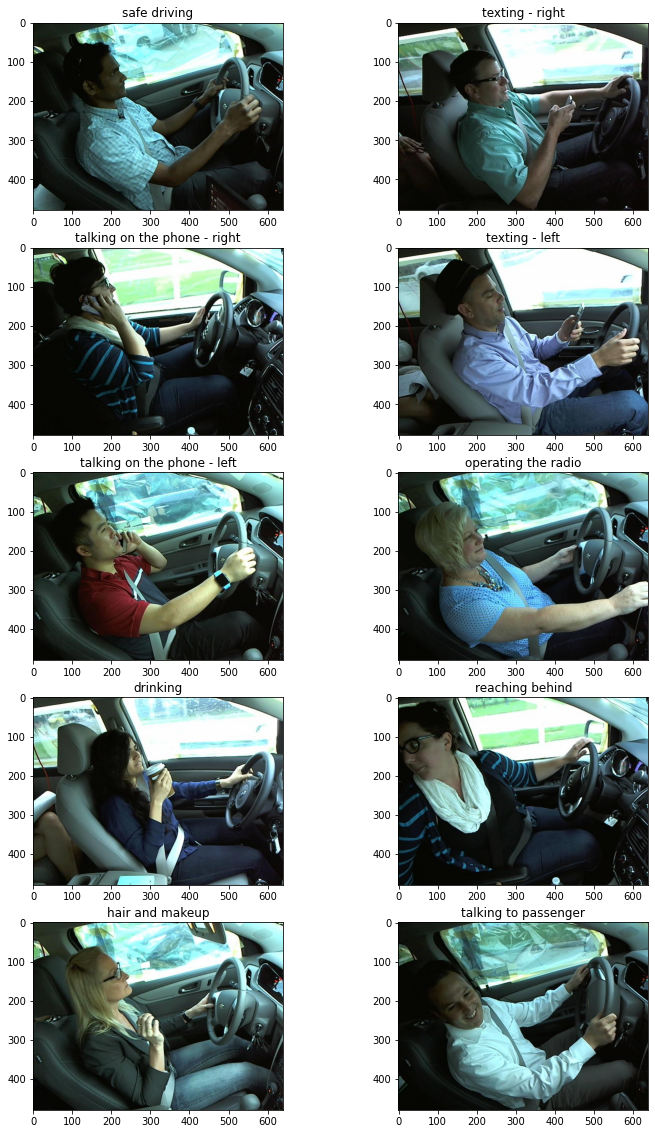

In [ ]:
plt.figure(figsize = (12, 20))
image_count = 1
base_url = '/content/drive/MyDrive/capstone/assets/imgs/train/'
for directory in os.listdir(base_url):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(base_url + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(base_url + directory + '/' + file)
                plt.imshow(image)
                plt.title(classes[directory])

# Sample of image

In this section, we will begin to preprocess the images in preparation for modelling. 

We will first convert the images into grayscale as colour is not essential in prediction of distracted drivers.

Next we will normalize all the images to the same size 

(480, 640)


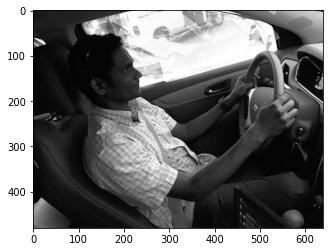

In [ ]:
DATADIR = '/content/drive/MyDrive/capstone/assets/imgs/train/'
LABELS = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

for label in LABELS:
    path = os.path.join(DATADIR, label) #path to labels directory
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        img_array = color.rgb2gray(img_array)
        plt.imshow(img_array, cmap='gray')
        break
    break
print(img_array.shape)

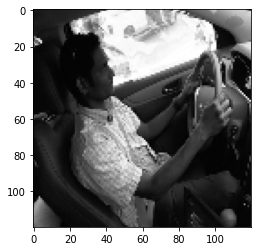

In [ ]:
IMG_SIZE = 120

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')

# Load Images

In [ ]:
#code has been run on Jupyter Notebook in local device

# def create_training_data():
#     training_data = []
#     for label in LABELS:
#         path = os.path.join(DATADIR, label) #path to labels directory
#         class_num = LABELS.index(label)
#         for img in os.listdir(path):
#             img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
#             new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
#             training_data.append([new_array, class_num])
            
#     return training_data
            
# images = create_training_data()    #ran on jupyter notebook
# len(images) #ran on jupyter notebook

# Further preprocessing

Here we will create our feature and target lists, which in this case is our images and classes respectively. 

In [ ]:
#code has been run on Jupyter Notebook in local device

# def preprocessing():
#     X=[]
#     y=[]
#     for features, classes in images:
#         X.append(features)
#         y.append(classes)
#     X = np.array(X, dtype=np.float32)
#     X = X.reshape(X.shape[0],X.shape[1],X.shape[2],-1)
#     #num_classes = len(classes)
#     y = np_utils.to_categorical(y, 10)
#     return X,y 

# #X, y = preprocessing()
# #print(X.shape)
# #print(y.shape)

# Load X and y variables from google drive

In [ ]:
def load_arr(filename):
    with open(filename, 'rb') as f:
        return np.load(f)

In [ ]:
X = load_arr('/content/drive/MyDrive/capstone/code/data_leakage/X.npy')
y = load_arr('/content/drive/MyDrive/capstone/code/data_leakage/y.npy')
print(X.shape)
print(y.shape)

(22424, 120, 120, 1)
(22424, 10)


# Train Test Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

print("Shape of X_train: ",X_train.shape)
#print("Shape of y_train: ",len(y_train))
print("Shape of y_train: ",y_train.shape)

print("Shape of X_val: ",X_val.shape)
#print("Shape of y_train: ",len(y_val))
print("Shape of y_val: ",y_val.shape)

Shape of X_train:  (17939, 120, 120, 1)
Shape of y_train:  (17939, 10)
Shape of X_val:  (4485, 120, 120, 1)
Shape of y_val:  (4485, 10)


We have split the data into 80/20 split where we have set aside validation data(X_val, y_val) of 4485 to be tested on later.  

Hence we will further split using the same 80/20 on the train data to do our initial analysis on. 

In [ ]:
X_train_mod, X_test, y_train_mod, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size = 0.2, random_state = 42)

print("Shape of X_train_mod: ",X_train_mod.shape)
#print("Shape of y_train_mod: ",len(y_train_mod))
print("Shape of y_train_mod: ",y_train_mod.shape)

print("Shape of X_test: ",X_test.shape)
#print("Shape of y_test: ",len(y_test))
print("Shape of y_test: ",y_test.shape)

Shape of X_train_mod:  (14351, 120, 120, 1)
Shape of y_train_mod:  (14351, 10)
Shape of X_test:  (3588, 120, 120, 1)
Shape of y_test:  (3588, 10)


In [ ]:
def ss_img(X_train, X_test):
    X_train_flat = X_train.reshape(X_train.shape[0],-1)
    X_test_flat = X_test.reshape(X_test.shape[0],-1)

    ss = StandardScaler()
    X_train_flat = ss.fit_transform(X_train_flat)
    X_test_flat = ss.transform(X_test_flat)
    
    X_train = X_train_flat.reshape(X_train.shape[0], X_train.shape[1],X_train.shape[2],-1)
    X_test = X_test_flat.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], -1)
    
    print(X_train.shape)
    print(X_test.shape)
    
    return X_train, X_test

X_train_mod, X_test = ss_img(X_train_mod, X_test)

(14351, 120, 120, 1)
(3588, 120, 120, 1)


# CNN with 1 Convolutional Layer from Scratch

We will first build a plain vanilla 1-layerd CNN model from scratch to get a indication of how well CNN performs on the initial data that we have processed so far.

In [ ]:
def cnn_1():
    #instantiate model
    model = Sequential()
    #add convolutional layer
    model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    #add pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #add dropout layer
    model.add(Dropout(0.5))
    #flatten
    model.add(Flatten())
    #add dense layer
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    return model

In [ ]:
# trans = StandardScaler()
# model = cnn_1()
# pipeline = Pipeline(steps = [("t", trans), ("m", model)])
# cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=1, random_state=42)
# n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs = -1)

In [ ]:
model = cnn_1()

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode='auto')

# Fit model
history = model.fit(X_train_mod,
                    y_train_mod,
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=25,
                    verbose=1,
                    callbacks = [early_stop],
                    workers=-1)

Epoch 1/25
57/57 [==============================] - 10s 144ms/step - loss: 1.8956 - accuracy: 0.3514 - val_loss: 1.2747 - val_accuracy: 0.5220
Epoch 2/25
57/57 [==============================] - 8s 137ms/step - loss: 0.9186 - accuracy: 0.7182 - val_loss: 0.8139 - val_accuracy: 0.7076
Epoch 3/25
57/57 [==============================] - 8s 137ms/step - loss: 0.4298 - accuracy: 0.8886 - val_loss: 0.3483 - val_accuracy: 0.8963
Epoch 4/25
57/57 [==============================] - 8s 137ms/step - loss: 0.2451 - accuracy: 0.9415 - val_loss: 0.2153 - val_accuracy: 0.9434
Epoch 5/25
57/57 [==============================] - 8s 137ms/step - loss: 0.1293 - accuracy: 0.9782 - val_loss: 0.2765 - val_accuracy: 0.9103
Epoch 6/25
57/57 [==============================] - 8s 137ms/step - loss: 0.1975 - accuracy: 0.9545 - val_loss: 0.1071 - val_accuracy: 0.9774
Epoch 7/25
57/57 [==============================] - 8s 137ms/step - loss: 0.0734 - accuracy: 0.9883 - val_loss: 0.3641 - val_accuracy: 0.8874
Epoch

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 59, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 445568)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               114065664 
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 114,069,514
Trainable params: 114,069,514
Non-trainable params: 0
__________________________________________

In [ ]:
# Evaluate model on test data.
cnn1_test_score = model.evaluate(X_test, y_test, verbose=1)

cnn1_test_labels = model.metrics_names

print(f'CNN1_test {cnn1_test_labels[0]}  : {cnn1_test_score[0]}')
print(f'CNN1_test {cnn1_test_labels[1]}   : {cnn1_test_score[1]}')

113/113 [==============================] - 1s 8ms/step - loss: 0.0272 - accuracy: 0.9930
CNN1_test loss  : 0.027178624644875526
CNN1_test accuracy   : 0.9930323362350464


In [ ]:
#model.save('../models')

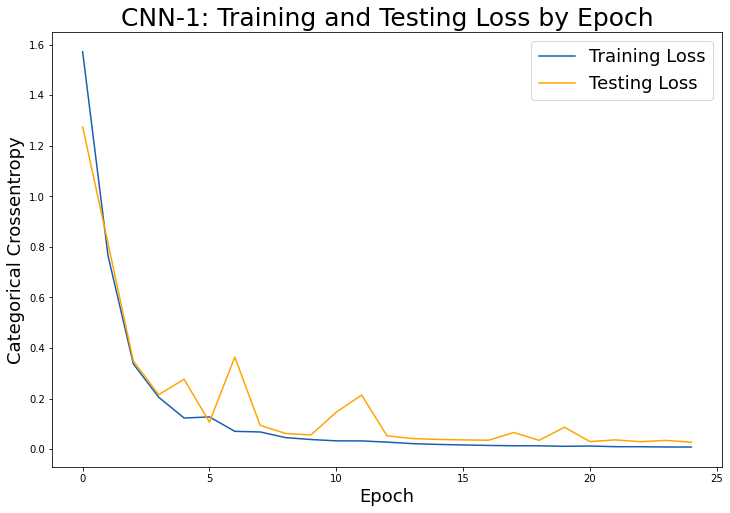

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss_1 = history.history['loss']
test_loss_1 = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss_1, label='Training Loss', color='#185fad')
plt.plot(test_loss_1, label='Testing Loss', color='orange')

# Set title
plt.title('CNN-1: Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

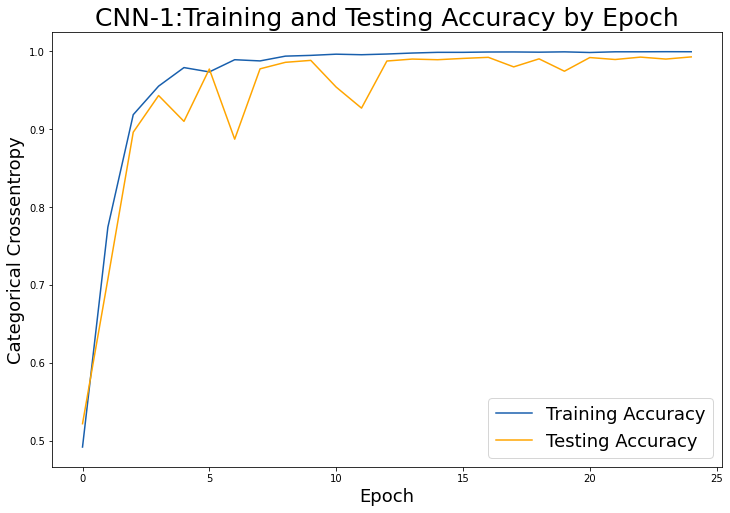

In [ ]:
# Check out our train acc and test acc over epochs.
train_acc_1 = history.history['accuracy']
test_acc_1 = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc_1, label='Training Accuracy', color='#185fad')
plt.plot(test_acc_1, label='Testing Accuracy', color='orange')

# Set title
plt.title('CNN-1:Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)


plt.legend(fontsize = 18);

# Test on training set

In [ ]:
X_train, X_val = ss_img(X_train, X_val)

(17939, 120, 120, 1)
(4485, 120, 120, 1)


In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode='auto')

# Fit model
history_val = model.fit(X_train,
                        y_train,
                        batch_size=256,
                        validation_data=(X_val, y_val),
                        epochs=30,
                        verbose=1,
                        callbacks = [early_stop],
                        workers = -1)

Epoch 1/30
71/71 [==============================] - 10s 140ms/step - loss: 0.0124 - accuracy: 0.9983 - val_loss: 0.5253 - val_accuracy: 0.8767
Epoch 2/30
71/71 [==============================] - 10s 137ms/step - loss: 0.0538 - accuracy: 0.9919 - val_loss: 0.0451 - val_accuracy: 0.9915
Epoch 3/30
71/71 [==============================] - 10s 137ms/step - loss: 0.0099 - accuracy: 0.9991 - val_loss: 0.0428 - val_accuracy: 0.9920
Epoch 4/30
71/71 [==============================] - 10s 137ms/step - loss: 0.0083 - accuracy: 0.9997 - val_loss: 0.0428 - val_accuracy: 0.9915
Epoch 5/30
71/71 [==============================] - 10s 137ms/step - loss: 0.0083 - accuracy: 0.9993 - val_loss: 0.0434 - val_accuracy: 0.9920
Epoch 6/30
71/71 [==============================] - 10s 137ms/step - loss: 0.0076 - accuracy: 0.9994 - val_loss: 0.0401 - val_accuracy: 0.9929
Epoch 7/30
71/71 [==============================] - 10s 137ms/step - loss: 0.0065 - accuracy: 0.9998 - val_loss: 0.0398 - val_accuracy: 0.9926

In [ ]:
# Evaluate model on val data.
cnn1_val_score = model.evaluate(X_val, y_val, verbose=1)

cnn1_val_labels = model.metrics_names

print(f'CNN1_val {cnn1_val_labels[0]}  : {cnn1_val_score[0]}')
print(f'CNN1_val {cnn1_val_labels[1]}   : {cnn1_val_score[1]}')

141/141 [==============================] - 1s 8ms/step - loss: 0.0383 - accuracy: 0.9924
CNN1_val loss  : 0.03829863667488098
CNN1_val accuracy   : 0.9924191832542419


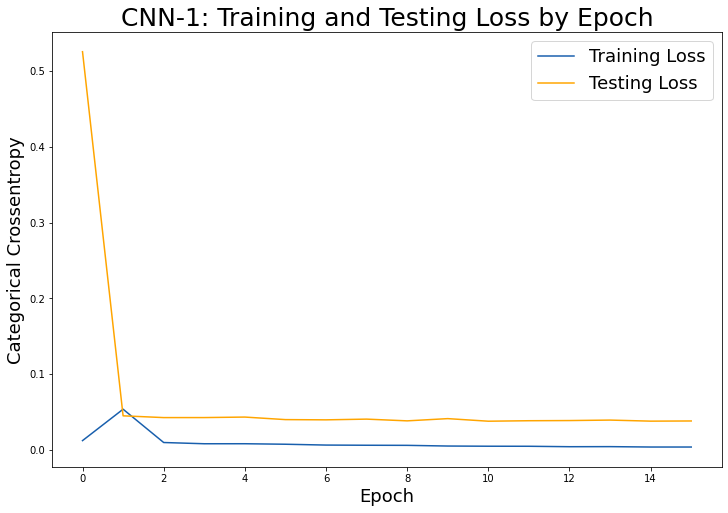

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss_val = history_val.history['loss']
test_loss_val = history_val.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss_val, label='Training Loss', color='#185fad')
plt.plot(test_loss_val, label='Testing Loss', color='orange')

# Set title
plt.title('CNN-1: Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

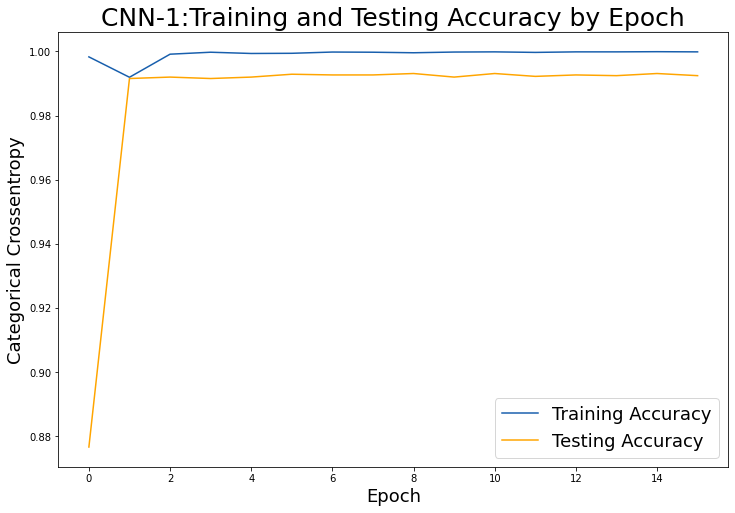

In [ ]:
# Check out our train acc and test acc over epochs.
train_acc_val = history_val.history['accuracy']
test_acc_val = history_val.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc_val, label='Training Accuracy', color='#185fad')
plt.plot(test_acc_val, label='Testing Accuracy', color='orange')

# Set title
plt.title('CNN-1:Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

# Evaluation


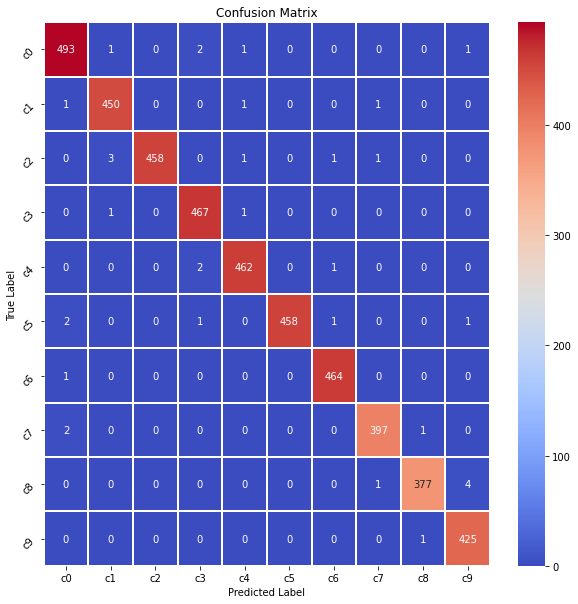

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       498
           1       0.99      0.99      0.99       453
           2       1.00      0.99      0.99       464
           3       0.99      1.00      0.99       469
           4       0.99      0.99      0.99       465
           5       1.00      0.99      0.99       463
           6       0.99      1.00      1.00       465
           7       0.99      0.99      0.99       400
           8       0.99      0.99      0.99       382
           9       0.99      1.00      0.99       426

    accuracy                           0.99      4485
   macro avg       0.99      0.99      0.99      4485
weighted avg       0.99      0.99      0.99      4485



In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=classes,
                yticklabels=classes,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label', rotation=90)
    plt.xlabel('Predicted Label')
    plt.yticks(rotation=45)
    plt.show()

y_pred = model.predict(X_val)
# Take the class with the highest probability from the test predictions
max_y_pred = np.argmax(y_pred, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred)

print(classification_report(max_y_val, max_y_pred))


# Predicted Images

In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

In [ ]:
# preds = model.predict(X_test)

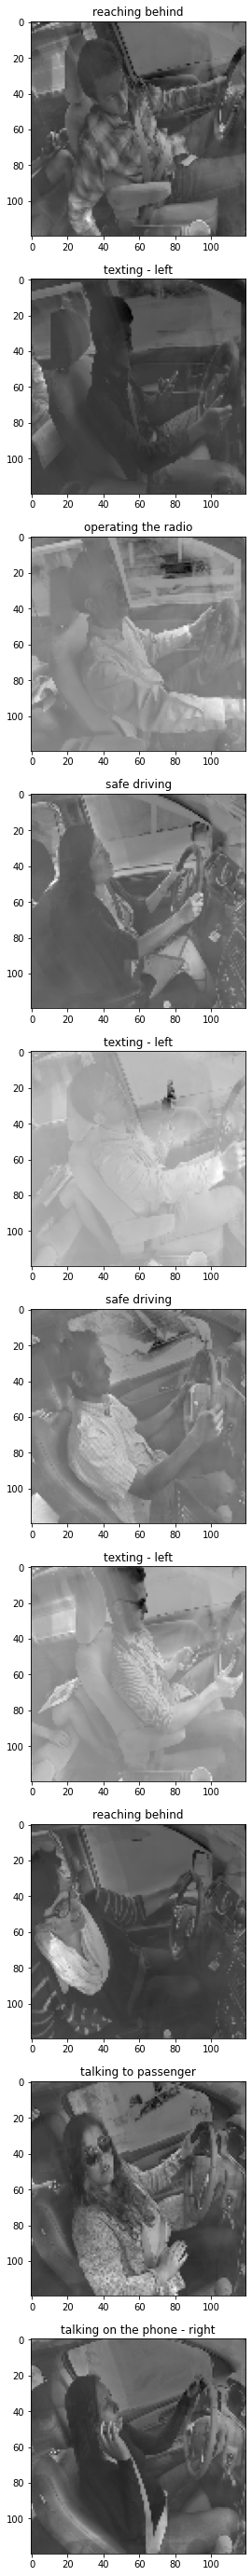

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(10, 1, figsize = (50,50))

for i in range(10):
    ax[i].imshow(X_val[i].squeeze(),cmap = 'gray')
    preds_class = 'C'+str(np.where(y_pred[i] == np.amax(y_pred[i]))[0][0])
    ax[i].set_title(tags[preds_class])
    plt.show

# Test on unseen/unlabelled data

In [ ]:
#below code was ran on jupyter notebook in desktop

# def create_test():
#     path = '/content/drive/MyDrive/capstone/assets/imgs/test/'
#     test = []
#     image_names=[]
#     for img in os.listdir(path):
#         img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
#         new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
#         test.append([new_array])
#         image_names.append(img)
        
#     return test, image_names
        
# test, image_names = create_test()

In [ ]:
#below code was ran on jupyter notebook in desktop

# def preprocess_test(images):
#     test_array = np.array(images, dtype=np.float32)
#     test_flat = test_array.reshape(test_array.shape[0],-1)
#     ss_test = StandardScaler()
#     test_ss = ss_test.fit_transform(test_flat)
#     test_final = test_ss.reshape(test_array.shape[0],test_array.shape[2],test_array.shape[3],1)
#     return test_final

In [ ]:
#load saved unlabelled images from google drive
test= load_arr('/content/drive/MyDrive/capstone/code/test_data/test.npy')
print(len(test))

10


In [ ]:
test.reshape(-1,120,120,1)
test.shape

(10, 120, 120, 1)

In [ ]:
predictions = model.predict(test)

In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

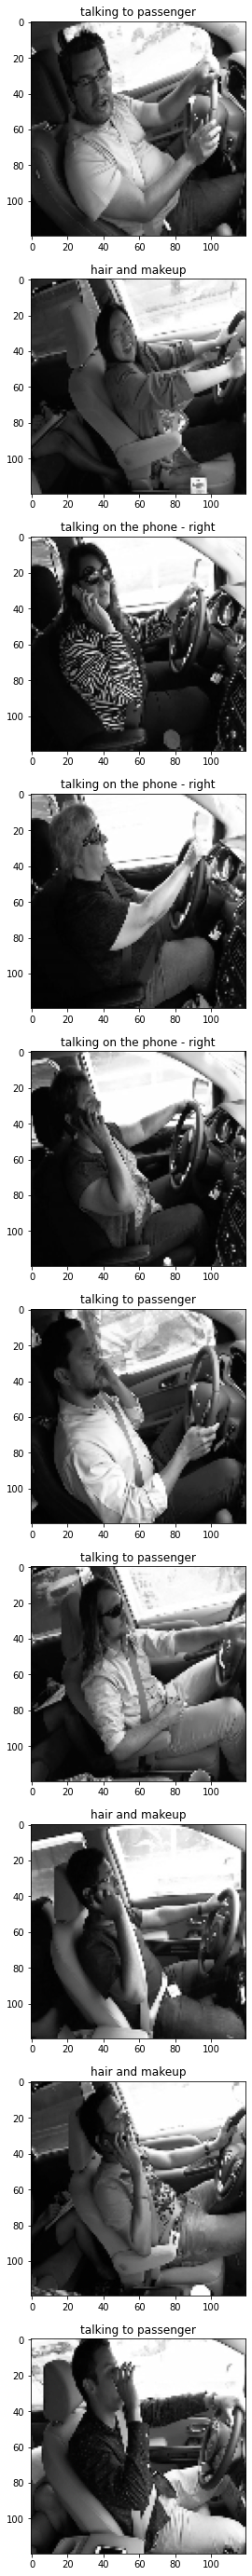

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(10, 1, figsize = (50,50))

for i in range(10):
    ax[i].imshow(test[i].squeeze(), cmap = 'gray')
    predicted_class = 'C'+str(np.where(predictions[i] == np.amax(predictions[i]))[0][0])
    ax[i].set_title(tags[predicted_class])

We knew that the accuracy on the training set was too good to be true!

Generalising the model in the unseen data yields underperforming results as compared to the results in the training set.

This is probably due to the fact that there was data leakage in the validation set when training the model on the test set. The model was basically training to predict the same images if was input to.

In the next notebook, we will address the data leakage by spiliting the images by driver id instead. This will give a better generalisation of the data and a more realistic accuracy.